# Task Description : 
Develop a Deep Neural Network model to predict the **PE** for the given **input data** . Please keep in mind the following:


*   1 bonus point - **(functioning model)** and 1 bonus point - **(top 5 models)**.
*   Submission Deadline is **June 9, 23:59**.
*   Please submit only .ipynb file for consistency.
*   Do not copy code from other students otherwise you will not be graded.
*   Try to write the code cleanly and only write what is asked in the final submission file.





*We expect you to upload  ('one' python file with name ***Exercise_4_Task_yourname***  and 'one' model.h5 with name **your_name_final_model.h5** file which contains your final trained model) on elearning in exactly the same format as explained below.*

**Special Note:** 

You need to model DNN using  **only pytorch library**. In the class we modelled DNN using tensorflow.keras library. Please use this [link](https://github.com/edgarsmdn/MLCE_book/blob/main/04_DNN_VLE.ipynb) to understand how to model DNN using pytorch and also to know which libraries to import.

In [74]:
#import all required libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [75]:
# upload data here (use the data provided on github under the task description)
df = pd.read_csv('https://raw.githubusercontent.com/carolineganzer/OVGU_MLCE_2023/main/Exercise_4_bonus_task/CCPP_training_data.csv')
df.head()

,AT,V,AP,RH,PE
0,14.12,41.39,1018.73,76.51,472.88
1,20.10,58.95,1018.46,80.87,446.70
2,30.53,65.18,1012.69,41.85,437.89
3,12.24,44.92,1023.74,88.21,473.26
4,31.16,64.96,1001.71,44.85,425.82


In [76]:
# perform data cleaning if required and define corresponding variables for [inputs /features]  and [corresponding output (Experimental values)]
# Please note: Input/Features are AT,V,AP,RH and Output is PE 

In [77]:
df.describe()

,AT,V,AP,RH,PE
count,7654.000000,7654.000000,7654.000000,7654.000000,7654.000000
mean,19.683840,54.300686,1013.256194,73.247823,454.347068
std,7.451376,12.703670,5.915586,14.654963,17.034607
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.550000,41.670000,1009.112500,63.212500,439.762500
50%,20.400000,52.300000,1012.990000,74.905000,451.515000
75%,25.720000,66.510000,1017.260000,84.757500,468.445000
max,37.110000,80.250000,1033.300000,100.160000,495.760000


In [78]:
df = df[(df['AT'].notna() & df['V'].notna() & df['AP'].notna() & df['RH'].notna() & df['PE'].notna())]
df.shape

(7654, 5)

In [79]:
df = np.array(df)
#Input
X = df[:,0:4]

#output
y = df[:,4].reshape(-1,1)
y.min(),y.max()

(420.26, 495.76)

In [80]:
# Define the Feed-forward Neural Network model using PyTorch
class FFNNModel(nn.Module):
    def __init__(self, layer_sizes, regularization_value):
        super(FFNNModel, self).__init__()
        self.layer_sizes = layer_sizes if layer_sizes else [1]  # Assign a default value if layer_sizes is empty
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(4, self.layer_sizes[0]))
        
        for i in range(1, len(self.layer_sizes)):
            self.layers.append(nn.Linear(self.layer_sizes[i-1], self.layer_sizes[i]))
        
        self.output_layer = nn.Linear(self.layer_sizes[-1], 1)
        
        self.relu = nn.ReLU()
        self.regularization = nn.L1Loss(reduction='mean')
        self.regularization_value = regularization_value

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        
        output = self.output_layer(x)
        return output
    
    def get_params(self, deep=True):
        return {
            'layer_sizes': self.layer_sizes,
            'regularization_value': self.regularization_value
        }

    def set_params(self, **params):
        if 'layer_sizes' in params:
            self.layer_sizes = params['layer_sizes']
        
        if 'regularization_value' in params:
            self.regularization_value = params['regularization_value']

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(4, self.layer_sizes[0]))
        
        for i in range(1, len(self.layer_sizes)):
            self.layers.append(nn.Linear(self.layer_sizes[i-1], self.layer_sizes[i]))
        
        self.output_layer = nn.Linear(self.layer_sizes[-1], 1)

In [81]:
# Custom estimator class for PyTorch model
class PyTorchEstimator(BaseEstimator):
    def __init__(self, model, epochs=25, batch_size=50, learning_rate=0.05):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def fit(self, X, y):
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.MSELoss()

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

    def predict(self, X):
        with torch.no_grad():
            return self.model(X).detach().numpy()

In [82]:
# Load and preprocess your data
# ...

# Scale the input data
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

# Convert the data to PyTorch tensors
X_tensor = torch.Tensor(X_scaled)
y_tensor = torch.Tensor(y)

In [83]:
# do cross validation using GridsearchCv as done in the lecture

In [84]:
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=100)


# Define the PyTorch model
model = FFNNModel(layer_sizes=[], regularization_value=0.001)

# Create the PyTorch estimator
estimator = PyTorchEstimator(model=model, epochs=25, batch_size=50, learning_rate=0.05)

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__layer_sizes': [[1,1],[2,2],[3,3],[4,4],[10],[10, 20],[10, 20, 30]],
    'model__regularization_value': [0.001],
    'learning_rate': [0.05],
    'epochs': [25],
    'batch_size': [50]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator, param_grid, scoring=make_scorer(r2_score), cv=3)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_.model
best_hyperparameters = grid_search.best_params_

print('Best model hyperparameters:', best_hyperparameters)

Best model hyperparameters: {'batch_size': 50, 'epochs': 25, 'learning_rate': 0.05, 'model__layer_sizes': [10], 'model__regularization_value': 0.001}


In [ ]:
# Print model summary
def print_model_summary(model):
    print(model)
    print("Model Summary:")
    print("==============")
    print("Layer-wise Parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name} | Size: {param.size()}")
    print("Total Trainable Parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))


print_model_summary(best_model)

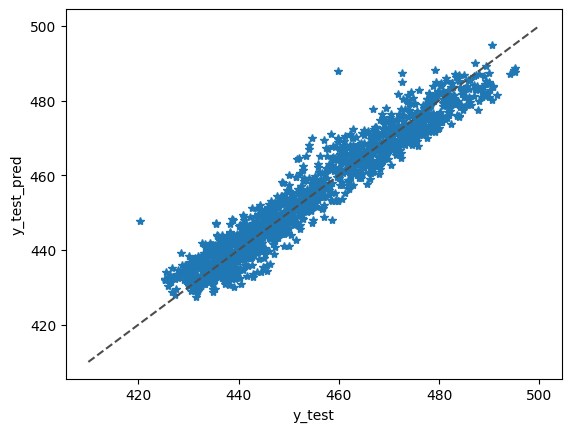

R2: 0.9344032470152323
MAPE: 0.007669261


In [86]:
# Convert the test data to PyTorch tensors
X_test_tensor = torch.Tensor(X_val)

# Predict on the test set
y_test_pred = best_model(X_test_tensor).detach().numpy()

# Plot the results
plt.figure()
plt.plot(y_val, y_test_pred, '*')
plt.plot([410, 500], [410, 500], ls="--", c=".3")
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.show()

# Calculate R2 score on the test set
r2 = r2_score(y_val, y_test_pred)
print('R2:', r2)
print('MAPE:', MAPE(y_val,y_test_pred))

In [87]:
# train your final model using all the available data points with optimized hyperparamters (found in best model of GridsearchCv)

In [88]:
# Train the final model using all available data and optimized hyperparameters
final_model = PyTorchEstimator(model=best_model, epochs=best_hyperparameters['epochs'],
                               batch_size=best_hyperparameters['batch_size'],
                               learning_rate=best_hyperparameters['learning_rate'])

final_model.fit(X_tensor, y_tensor)

In [89]:
# write code to save your final trained model and download the saved file with name 'your_name_final_model.h5' to submit along with this python file

In [95]:
# Save the final trained model
torch.save(final_model.model.state_dict(), 'Joseph_final_model.h5')

In [96]:
# Download the saved model file

from google.colab import files

files.download('Joseph_final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
# At last write the final function in exactly the same format as taught in class.

In [99]:
def Joseph_model(df):
    X = df[:, 0:4]
    y = df[:, 4].reshape(-1, 1)
    
    # Scale the input data
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X)
    
    # Load the trained model
    model = torch.load('/content/Joseph_final_model.h5')
    
    # Convert the data to PyTorch tensors
    X_tensor = torch.Tensor(X_scaled)
    
    # Make predictions using the trained model
    with torch.no_grad():
        y_pred = model(X_tensor).numpy()
    
    # Plot the results
    plt.figure()
    plt.plot(y, y_pred, '*')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    # Calculate R2 score
    r2 = r2_score(y, y_pred)
    return r2

**Special Note:**

You need to model DNN using only pytorch library. In the class we modelled DNN using tensorflow.keras library.[link](https://github.com/edgarsmdn/MLCE_book/blob/main/04_DNN_VLE.ipynb) to understand how to model DNN using pytorch and also to know which libraries to import. Using this link you can also learn and are free to add **Early stopping**, change **regularizers** etc. to define your model.